In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *

In [2]:
# for plotting
plt.rcParams.update({'font.size': 16})

In [3]:
exp_meta_data_dir = '../meta_data/exp'
exp_data_dir = '../processed_data/exp'

# Load data from experiments

## LFP and CSD

In [4]:
# Load meta data
manifest_path = os.path.join(exp_meta_data_dir, 'ecephys_cache_dir_10_31', "manifest.json")
#manifest_path = os.path.join(exp_meta_data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

channels = cache.get_channels()
probes = cache.get_probes()

In [11]:
trial_window_start = -1.0
trial_window_end = 0.5


loadpaths_csd = sorted(glob(os.path.join(exp_data_dir, 'csd', 
            'trial_window_'+str(trial_window_start).replace('.','pnt')+\
             '_to_'+str(trial_window_end).replace('.','pnt')+'s', '*')))
loadpaths_lfp = sorted(glob(os.path.join(exp_data_dir, 'lfp', 'trial_window_'\
             +str(trial_window_start).replace('.','pnt')+\
             '_to_'+str(trial_window_end).replace('.','pnt')+'s', '*')))
    
len(loadpaths_csd)

53

In [12]:
twoi_start = -0.0
twoi_end = 0.1

Fs = 1250 # Hz

In [13]:
session_ids = list() # all session ids
sessions_channels_vert_pos = dict()
sessions_csd_trial_avg = dict()
sessions_csd_all_trials = dict()

for i, file_path in enumerate(loadpaths_csd):
    session_id = os.path.basename(file_path).split('_')[0]
    print('Session id: ', session_id)
    data = np.load(file_path, allow_pickle = True)
        
    session_ids.append(session_id)
        
    t = np.array(data[()]['csd_mean']['time_from_presentation_onset'])
    t_min = twoi_start; t_max = twoi_end
    mask = np.logical_and(t>=t_min, t<=t_max)
    t = t[mask]
    
    channels_vert_pos = data[()]['channel_vertical_pos']
    channels_vert_pos = channels_vert_pos[::-1]
    channels_vert_pos -= channels_vert_pos.max()
    sessions_channels_vert_pos[session_id] = channels_vert_pos
    
    mask_session = channels['ecephys_session_id'] == int(session_id)
    mask_structure = channels[mask_session]['ecephys_structure_acronym'] == 'VISp'
    dorsal_ventral_ccf_coordinate = channels[mask_session][mask_structure]['dorsal_ventral_ccf_coordinate']
    channel_ids_csd = data[()]['csd_mean'].channel.values
    dorsal_ventral_ccf_coordinate = -(dorsal_ventral_ccf_coordinate[channel_ids_csd]-dorsal_ventral_ccf_coordinate[channel_ids_csd].min())# higher dorsal-ventral value means more ventral
    
    if ~np.all(np.isnan(dorsal_ventral_ccf_coordinate)): # if all NaNs it means exact probe location not recovered
        csd_trial_avg = data[()]['csd_mean']
        csd_trial_avg = csd_trial_avg[:,mask]
        sessions_csd_trial_avg[session_id] = csd_trial_avg.values

        csd_all_trials = data[()]['csd']
        csd_all_trials = csd_all_trials[:,:,mask]
        sessions_csd_all_trials[session_id] = csd_all_trials.values

Session id:  715093703
Session id:  719161530
Session id:  721123822
Session id:  732592105
Session id:  737581020
Session id:  739448407
Session id:  742951821
Session id:  744228101
Session id:  746083955
Session id:  750332458
Session id:  750749662
Session id:  751348571
Session id:  754312389
Session id:  754829445
Session id:  755434585
Session id:  756029989
Session id:  757216464
Session id:  757970808
Session id:  758798717
Session id:  759883607
Session id:  760345702
Session id:  760693773
Session id:  761418226
Session id:  762120172
Session id:  762602078
Session id:  763673393
Session id:  766640955
Session id:  767871931
Session id:  768515987
Session id:  771160300
Session id:  771990200
Session id:  773418906
Session id:  774875821
Session id:  778240327
Session id:  778998620
Session id:  779839471
Session id:  781842082
Session id:  786091066
Session id:  787025148
Session id:  789848216
Session id:  791319847
Session id:  793224716
Session id:  794812542
Session id:

In [14]:
sessions_lfp_trial_avg = dict()
sessions_lfp_all_trials = dict()

structure = 'VISp'

for i, file_path in enumerate(loadpaths_lfp):
    session_id = os.path.basename(file_path).split('_')[0]
    print('Session id: ', session_id)
    
    data = np.load(file_path, allow_pickle = True)[()][structure]
    
    if data == None:
        continue
        
    mask_session = channels['ecephys_session_id'] == int(session_id)
    mask_structure = channels[mask_session]['ecephys_structure_acronym'] == 'VISp'
    dorsal_ventral_ccf_coordinate = channels[mask_session][mask_structure]['dorsal_ventral_ccf_coordinate']
    channel_ids_csd = data['lfp_trial_avg'].channel.values
    dorsal_ventral_ccf_coordinate = -(dorsal_ventral_ccf_coordinate[channel_ids_csd]-dorsal_ventral_ccf_coordinate[channel_ids_csd].min())# higher dorsal-ventral value means more ventral
    
    if ~np.all(np.isnan(dorsal_ventral_ccf_coordinate)): # if all NaNs it means exact probe location not recovered
        t = np.array(data['lfp_trial_avg']['time_from_presentation_onset'])
        t_min = twoi_start; t_max = twoi_end
        mask_time = np.logical_and(t>=t_min, t<=t_max)
        t = t[mask_time]

        lfp_trial_avg = data['lfp_trial_avg'] 
        sessions_lfp_trial_avg[session_id] = lfp_trial_avg[:, mask_time]

        lfp_all_trials = data['lfp_all_trials']
        sessions_lfp_all_trials[session_id] = lfp_all_trials[:, :, mask_time]

Session id:  715093703
Session id:  719161530
Session id:  721123822
Session id:  732592105
Session id:  737581020
Session id:  739448407
Session id:  742951821
Session id:  744228101
Session id:  746083955
Session id:  750332458
Session id:  750749662
Session id:  751348571
Session id:  754312389
Session id:  754829445
Session id:  755434585
Session id:  756029989
Session id:  757216464
Session id:  757970808
Session id:  758798717
Session id:  759883607
Session id:  760345702
Session id:  760693773
Session id:  761418226
Session id:  762120172
Session id:  762602078
Session id:  763673393
Session id:  766640955
Session id:  767871931
Session id:  768515987
Session id:  771160300
Session id:  771990200
Session id:  773418906
Session id:  774875821
Session id:  778240327
Session id:  778998620
Session id:  779839471
Session id:  781842082
Session id:  786091066
Session id:  787025148
Session id:  789848216
Session id:  791319847
Session id:  793224716
Session id:  794812542
Session id:

## Spikes

In [15]:
exp_spike_data_dir = os.path.join(exp_data_dir, 'spikes', 'V1')
filename = 'sessions_spike_counts_-1to0pnt5s_white_flash.npy'

loadpath = os.path.join(exp_spike_data_dir, filename)

sessions_spike_trains_V1 = np.load(loadpath, allow_pickle = True)[()]

#### Load meta data

In [16]:
units = cache.get_units()

# Make figures

### Spikes

In [17]:
sessions_ncells_V1 = dict()
for session_id_ in sessions_spike_trains_V1.keys():
    ncells = 0
    for unit_type in sessions_spike_trains_V1[session_id_].keys():
        ncells += sessions_spike_trains_V1[session_id_][unit_type].shape[-1]
        
    sessions_ncells_V1[session_id_] = ncells

In [18]:
#session_id = list(sessions_spike_trains_V1.keys())[0]
session_id = np.array(list(sessions_ncells_V1.keys()))\
                 [np.argsort(np.array(list(sessions_ncells_V1.values())))][-4]
print(session_id)
exc_spike_trains = sessions_spike_trains_V1[session_id]['exc']
inh_spike_trains = sessions_spike_trains_V1[session_id]['inh']

754312389


In [19]:
filename = 'units_cortical_depth_'+str(session_id)+'.csv'
loadpath = os.path.join(exp_meta_data_dir, 'units_cortical_depth', filename)
units_depth = pd.read_csv(loadpath, sep=' ')
units_depth = units_depth.set_index('id')

In [20]:


t = exc_spike_trains.time_relative_to_stimulus_onset.values
t_min = -0.1; t_max = 0.105
mask_time = np.logical_and(t>=t_min, t<=t_max)
t = t[mask_time]
exc_spike_trains = exc_spike_trains[:,mask_time]
inh_spike_trains = inh_spike_trains[:,mask_time]



In [21]:
inds_cells_rising_fir_rate = np.argsort(np.mean(np.mean(exc_spike_trains, axis = 0), axis = 0)).values

In [22]:
i_st = inds_cells_rising_fir_rate[-14]
spike_train = exc_spike_trains[:, :, i_st]

In [23]:
i_st = np.where(exc_spike_trains.unit_id.values == 951797465)[0][0]
spike_train = exc_spike_trains[:, :, i_st]
nr_sel_nrn_sort_by_depth = np.where(units_depth.index == 951797465)[0][0]

In [24]:
# for plotting
plt.rcParams.update({'font.size': 20})

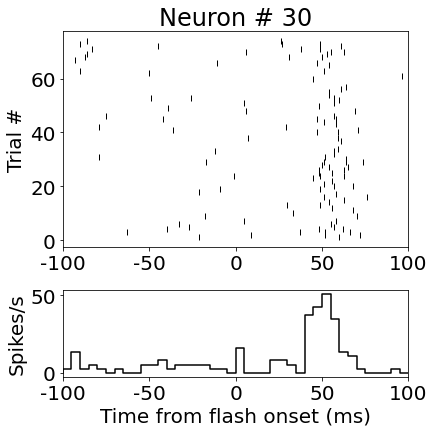

In [25]:

time_start_label = 0
time_stop_label = 100
time_step_label = 20
time_ticklabels = np.arange(time_start_label, time_stop_label+time_step_label, time_step_label)
sf = 1250
time_tick_step = int(time_step_label*sf/1E3)
time_ticks = np.arange(0, sessions_csd_trial_avg[str(session_id)].shape[-1]+time_tick_step, time_tick_step)


trials, timestamps = np.where(spike_train)

unit_id = spike_train.unit_id.values

fig = plt.figure(figsize = (6,6))

fig.subplots_adjust(left = 0.2, right = 0.9, bottom = 0.1, top = 0.9)

ax = fig.add_axes([0.15, 0.44, 0.8, 0.5])

ax.plot(timestamps, trials, '|', color = 'k')
ax.set_xticks(time_ticklabels)
ax.set_title('Neuron # '+str(nr_sel_nrn_sort_by_depth))

ax.set_xticks(np.arange(0,200+50,50))
ax.set_xticklabels(np.arange(-100,100+50,50))
ax.set_xlim([0,200])
ax.set_ylabel('Trial #')

ax = fig.add_axes([0.15, 0.14, 0.8, 0.2])

bin_size = 5 # ms
bins = np.arange(0, spike_train.shape[1]+bin_size, bin_size)
#ax.hist(timestamps, bins = bins, histtype = 'step', color = 'k')

fir_rate = np.histogram(timestamps, bins = bins)[0]/(bin_size*spike_train.shape[0])*1E3
ax.step(x = bins[:-1], y = fir_rate, color = 'k')

ax.set_xlim([0,200])
ax.set_xlabel('Time from flash onset (ms)')

ax.set_xticks(np.arange(0,200+50,50))
ax.set_xticklabels(np.arange(-100,100+50,50))

ax.margins(x=0)

ax.set_ylabel('Spikes/s')

filename = 'exp_spikes_'+str(session_id)+'_unit_'+str(unit_id)+'.png'

savepath = os.path.join('Figures', 'Figure_1', filename)

#fig.savefig(savepath, facecolor = 'w')'''

## Raster of spike trains from all cells

In [26]:

t = exc_spike_trains.time_relative_to_stimulus_onset.values
t_min = -0.1; t_max = 0.155
mask_time = np.logical_and(t>=t_min, t<=t_max)
t = t[mask_time]
exc_spike_trains = exc_spike_trains[:,mask_time]
inh_spike_trains = inh_spike_trains[:,mask_time]

In [27]:
itrial = 14
exc_spike_trains_single_trial = exc_spike_trains[itrial]
inh_spike_trains_single_trial = inh_spike_trains[itrial]

In [28]:
exc_units_depth = units_depth.loc[exc_spike_trains_single_trial.unit_id.values]['cortical_depth']
inh_units_depth = units_depth.loc[inh_spike_trains_single_trial.unit_id.values]['cortical_depth']

In [29]:
inds_sort_by_depth = np.argsort(exc_units_depth)
depth_exc_units_sorted = exc_units_depth.values[inds_sort_by_depth]
exc_spike_trains_depth_sorted = exc_spike_trains_single_trial[:,inds_sort_by_depth]

inds_sort_by_depth = np.argsort(inh_units_depth)
depth_inh_units_sorted = inh_units_depth.values[inds_sort_by_depth]
inh_spike_trains_depth_sorted = inh_spike_trains_single_trial[:,inds_sort_by_depth]

In [30]:
layer_exc_units_depth_sorted = units_depth.loc[exc_spike_trains_depth_sorted.unit_id.values]['cortical_layer'].values
layer_inh_units_depth_sorted = units_depth.loc[inh_spike_trains_depth_sorted.unit_id.values]['cortical_layer'].values

In [31]:
timestamps_exc, exc_unit_nrs = np.where(exc_spike_trains_depth_sorted)
timestamps_inh, inh_unit_nrs = np.where(inh_spike_trains_depth_sorted)

In [32]:
sel_session_ids = [761418226, 771160300, 763673393, 754312389, 719161530] # 771990200
sel_session_ids_nrs = dict()

for isess, session_id in enumerate(sel_session_ids):
    sel_session_ids_nrs[session_id] = isess+1

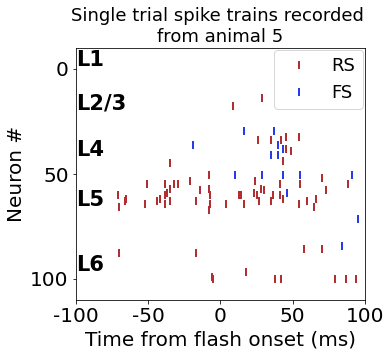

In [33]:
fig = plt.figure(figsize = (6,5))

ax = fig.add_subplot(1,1,1)

fig.subplots_adjust(left = 0.16, right = 0.83, bottom = 0.15, top = 0.85)

#mask_L6 = layer_exc_units_depth_sorted[exc_unit_nrs] == 6

ax.plot(timestamps_exc, depth_exc_units_sorted[exc_unit_nrs], '|', markeredgewidth = 2, markersize = 8, color = '#b22f31', label = 'RS')
ax.plot(timestamps_inh, depth_inh_units_sorted[inh_unit_nrs], '|', markeredgewidth = 2, markersize = 8, color = '#273be9', label = 'FS')
ax.set_ylim([-0.1, 1.1])
plt.gca().invert_yaxis()
#ax.set_yticks(np.linspace(0,1,5))
#ax.set_yticklabels(depth_ticklabels)
#ax.set_ylabel('Depth ($\mu$m)')

ax.set_yticks(np.linspace(0,1,3,endpoint=True))
ax.set_yticklabels(np.linspace(0, len(units_depth.index)-2, 3, endpoint = True, dtype = 'int'))

#ax.set_yticklabels(np.arange(0,50))
ax.set_ylabel('Neuron #')

plt.figtext(x = 0.16, y = 0.8, s = 'L1', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.16, y = 0.68, s = 'L2/3', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.16, y = 0.55, s = 'L4', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.16, y = 0.41, s = 'L5', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.16, y = 0.23, s = 'L6', fontsize = 21, fontweight = 560)

fig.legend(bbox_to_anchor = (0.845, 0.87), frameon = True, prop={"size":18})

ax.set_xlabel('Time from flash onset (ms)')

ax.set_xticks(np.arange(0,250+50,50))
ax.set_xticklabels(np.arange(-100,150+50,50))

ax.set_xlim([0,200])

ax.set_title('Single trial spike trains recorded \nfrom animal '+str(sel_session_ids_nrs[session_id]), fontsize = 18)

fig_name = 'exp-raster-session-'+str(session_id)+'-trial-'+str(itrial)+'_-100_to_100ms.png'

savepath = os.path.join('Figures', 'Figure_1', fig_name)

#fig.savefig(savepath, facecolor = 'w')

### LFP and CSD

In [34]:
#session_id = list(sessions_lfp_trial_avg.keys())[0]
session_id = str(np.array(list(sessions_ncells_V1.keys()))\
                 [np.argsort(np.array(list(sessions_ncells_V1.values())))][-4])
session_id, sessions_ncells_V1[int(session_id)]

('754312389', 102)

In [35]:

filename = 'cortical_depth_'+str(session_id)+'.csv'
loadpath = os.path.join(exp_meta_data_dir, 'probes_cortical_depths', filename)
df_depth = pd.read_csv(loadpath, sep=' ')


In [36]:
channel_step = 5
depth_ticks = np.arange(0, len(channels_vert_pos), channel_step)
depth_step = channel_step*np.diff(channels_vert_pos)[0]
depth_ticklabels = np.arange(channels_vert_pos[0], channels_vert_pos[-1]+depth_step, depth_step) 


time_start_label = 0
time_stop_label = 100
time_step_label = 20
time_ticklabels = np.arange(time_start_label, time_stop_label+time_step_label, time_step_label)
sf = 1250
time_tick_step = int(time_step_label*sf/1E3)
time_ticks = np.arange(0, sessions_csd_trial_avg[str(session_id)].shape[-1]+time_tick_step, time_tick_step)

In [37]:
# for plotting
plt.rcParams.update({'font.size': 16})

In [38]:
sel_session_ids = [761418226, 771160300, 763673393, 754312389, 719161530] # 771990200
sel_session_ids_nrs = dict()

for isess, session_id in enumerate(sel_session_ids):
    sel_session_ids_nrs[session_id] = isess+1

In [39]:
sel_session_ids_nrs

{761418226: 1, 771160300: 2, 763673393: 3, 754312389: 4, 719161530: 5}

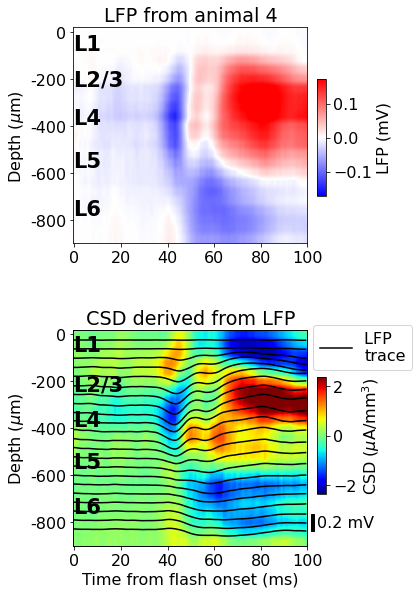

In [40]:
session_id = 754312389

fig, axes = plt.subplots(nrows = 2, figsize = (6.5, 9))

fig.subplots_adjust(hspace = 0.4, left = 0.18, right = 0.68, top = 0.9, bottom = 0.1)

scale_to_mV = 1E3

lfp_plot = sessions_lfp_trial_avg[str(session_id)]*scale_to_mV
cmap_range = np.abs(lfp_plot).max()/1.2
im = axes[0].imshow(lfp_plot, cmap = 'bwr', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

cbaxes = fig.add_axes([0.7,0.64,0.02, 0.18])
cb = fig.colorbar(im, ax = axes[0], cax = cbaxes)
cb.set_label('LFP (mV)')

scale_to_uA = 1E-3
csd_plot = sessions_csd_trial_avg[str(session_id)]*scale_to_uA
cmap_range = np.abs(csd_plot).max()/1.2
im = axes[1].imshow(csd_plot, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

cbaxes = fig.add_axes([0.7,0.18,0.02, 0.18])
cb = fig.colorbar(im, ax = axes[1], cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')


twin1 = axes[1].twinx()

trace_chans_step = 1
trace_chans_start = 1
for ichan in np.arange(trace_chans_start, lfp_plot.shape[0], trace_chans_step):
    #print(ichan)
    lfp_trace = lfp_plot[ichan]
    
    lfp_trace_plot = gaussian_filter(lfp_trace, sigma = 1)
    
    if ichan == lfp_plot.shape[0]-1:
        label = 'LFP \ntrace'
    else:
        label = None
    
    twin1.plot(lfp_trace_plot-0.5*ichan*lfp_plot.values.max()/trace_chans_step, color = 'k', label = label)
    
    
    
    '''axes[2].plot(lfp_trace_plot-ichan*2*0.1/trace_chans_step, color = 'k')
    
    csd_trace = csd_plot[ichan]
    
    csd_trace_plot = gaussian_filter(csd_trace, sigma = 2)
    
    twin2.plot(csd_trace_plot-2*ichan*csd_plot.max()/trace_chans_step, color = 'r')'''
    
    
axes[0].set_yticks(depth_ticks)
axes[0].set_yticklabels(depth_ticklabels)
axes[0].set_ylabel('Depth ($\mu$m)')

axes[1].set_yticks(depth_ticks)
axes[1].set_yticklabels(depth_ticklabels)
axes[1].set_ylabel('Depth ($\mu$m)')


axes[0].set_xticks(time_ticks)
axes[0].set_xticklabels(time_ticklabels)

axes[1].set_xticks(time_ticks)
axes[1].set_xticklabels(time_ticklabels)
axes[1].set_xlabel('Time from flash onset (ms)')


plt.figtext(x = 0.18, y = 0.865, s = 'L1', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.18, y = 0.81, s = 'L2/3', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.18, y = 0.75, s = 'L4', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.18, y = 0.685, s = 'L5', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.18, y = 0.61, s = 'L6', fontsize = 21, fontweight = 560)

plt.figtext(x = 0.18, y = 0.4, s = 'L1', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.18, y = 0.34, s = 'L2/3', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.18, y = 0.285, s = 'L4', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.18, y = 0.22, s = 'L5', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.18, y = 0.15, s = 'L6', fontsize = 21, fontweight = 560)



twin1.set_yticks([])

plt.legend(bbox_to_anchor = (0.99, 1.06))

axes[0].set_title('LFP from animal '+str(sel_session_ids_nrs[session_id]))
axes[1].set_title('CSD derived from LFP')

scalebar = AnchoredSizeBar(axes[1].transData,
                           1.5, '', loc = 4, 
                           pad=0.1,
                           color='black',
                           bbox_to_anchor = (1.04,-0.025),
                           bbox_transform = axes[1].transAxes,
                           label_top = False,
                           frameon=False,
                           size_vertical=1.8,)
axes[1].add_artist(scalebar)

plt.figtext(s= '0.2 mV', x = 0.7, y = 0.128)

filename = 'exp-LFP-to-CSD-'+str(session_id)+'.png'

savepath = os.path.join('Figures', 'Figure_1', filename)

#fig.savefig(savepath, facecolor = 'w')